# House Prices

The Plan:
- inspect data, exclude missing values, check distributions, check data types
- check for redundancies among categorical variables (contingency tables)
- check for redundancies among continuous variables (vif, correlation)
- check assumptions of glm (somewhat balanced categories)
- preprocess the data: scaling numerical variables
- build null model, full model
- build candidate models
- compare AICs

## Data inspection

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [119]:
df = pd.read_csv("housing.csv")

In [120]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: xlabel='SalePrice', ylabel='Count'>

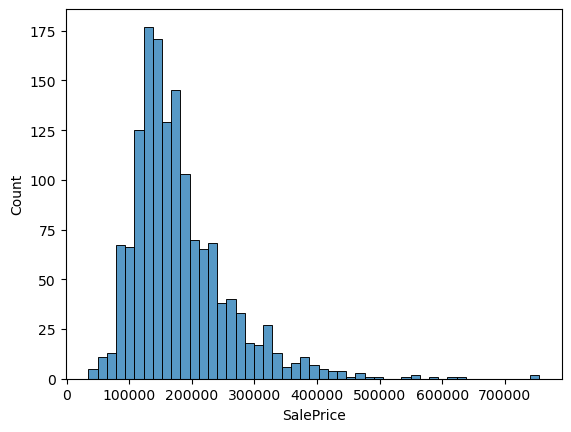

In [122]:
sns.histplot(x='SalePrice', data=df)

Our dependent variable is Poisson distributed, so we could use a GLM with Poisson distribution.

In [123]:
df_select = df[['MSSubClass','MSZoning','LotFrontage','LotArea','BldgType','OverallCond','CentralAir','GrLivArea','BedroomAbvGr','KitchenQual','Fireplaces','GarageArea','SaleCondition','SalePrice']]

In [124]:
df_select.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,BldgType,OverallCond,CentralAir,GrLivArea,BedroomAbvGr,KitchenQual,Fireplaces,GarageArea,SaleCondition,SalePrice
0,60,RL,65.0,8450,1Fam,5,Y,1710,3,Gd,0,548,Normal,208500
1,20,RL,80.0,9600,1Fam,8,Y,1262,3,TA,1,460,Normal,181500
2,60,RL,68.0,11250,1Fam,5,Y,1786,3,Gd,1,608,Normal,223500
3,70,RL,60.0,9550,1Fam,5,Y,1717,3,Gd,1,642,Abnorml,140000
4,60,RL,84.0,14260,1Fam,5,Y,2198,4,Gd,1,836,Normal,250000


In [125]:
df_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   BldgType       1460 non-null   object 
 5   OverallCond    1460 non-null   int64  
 6   CentralAir     1460 non-null   object 
 7   GrLivArea      1460 non-null   int64  
 8   BedroomAbvGr   1460 non-null   int64  
 9   KitchenQual    1460 non-null   object 
 10  Fireplaces     1460 non-null   int64  
 11  GarageArea     1460 non-null   int64  
 12  SaleCondition  1460 non-null   object 
 13  SalePrice      1460 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 159.8+ KB


In [126]:
df_select.dropna(inplace=True)
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1201 non-null   int64  
 1   MSZoning       1201 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1201 non-null   int64  
 4   BldgType       1201 non-null   object 
 5   OverallCond    1201 non-null   int64  
 6   CentralAir     1201 non-null   object 
 7   GrLivArea      1201 non-null   int64  
 8   BedroomAbvGr   1201 non-null   int64  
 9   KitchenQual    1201 non-null   object 
 10  Fireplaces     1201 non-null   int64  
 11  GarageArea     1201 non-null   int64  
 12  SaleCondition  1201 non-null   object 
 13  SalePrice      1201 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 140.7+ KB


C:\Users\pc\AppData\Local\Temp\ipykernel_26312\4116890144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.dropna(inplace=True)


We excluded any rows with missing values.

In [127]:
# Convert MSSubClass to object data type
df_select['MSSubClass'] = df_select['MSSubClass'].astype('object')

# Verify the data type conversion
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1201 non-null   object 
 1   MSZoning       1201 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1201 non-null   int64  
 4   BldgType       1201 non-null   object 
 5   OverallCond    1201 non-null   int64  
 6   CentralAir     1201 non-null   object 
 7   GrLivArea      1201 non-null   int64  
 8   BedroomAbvGr   1201 non-null   int64  
 9   KitchenQual    1201 non-null   object 
 10  Fireplaces     1201 non-null   int64  
 11  GarageArea     1201 non-null   int64  
 12  SaleCondition  1201 non-null   object 
 13  SalePrice      1201 non-null   int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 140.7+ KB


C:\Users\pc\AppData\Local\Temp\ipykernel_26312\2333860166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['MSSubClass'] = df_select['MSSubClass'].astype('object')


We converted the first columns to object data type because it is actually categorical.

## Preprocessing: scaling

In [128]:
# Separate SalePrice
sale_price = df_select['SalePrice']  # Preserve SalePrice column

# Separate numerical and categorical columns
df_num = df_select.select_dtypes(include=['number']).drop(columns=['SalePrice'])
df_cat = df_select.select_dtypes(exclude=['number'])
print(df_num.info())
print(df_cat.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   LotArea       1201 non-null   int64  
 2   OverallCond   1201 non-null   int64  
 3   GrLivArea     1201 non-null   int64  
 4   BedroomAbvGr  1201 non-null   int64  
 5   Fireplaces    1201 non-null   int64  
 6   GarageArea    1201 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 75.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1201 non-null   object
 1   MSZoning       1201 non-null   object
 2   BldgType       1201 non-null   object
 3   CentralAir     1201 non-null   object
 4   KitchenQual    1201 non-null   object
 5   SaleCondition  1201 non-null   object
dtypes: obj

In [129]:
# Apply MinMaxScaler to numerical columns
scaler = MinMaxScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

# Combine scaled numerical, encoded categorical, and SalePrice columns
df_processed = pd.concat([df_num_scaled, df_cat, sale_price], axis=1)

# Verify the resulting DataFrame
df_processed.head()

,LotFrontage,LotArea,OverallCond,GrLivArea,BedroomAbvGr,Fireplaces,GarageArea,MSSubClass,MSZoning,BldgType,CentralAir,KitchenQual,SaleCondition,SalePrice
0,0.150685,0.033420,0.428571,0.259231,0.375,0.000000,0.386460,60,RL,1Fam,Y,Gd,Normal,208500.0
1,0.202055,0.038795,0.857143,0.174830,0.375,0.333333,0.324401,20,RL,1Fam,Y,TA,Normal,181500.0
2,0.160959,0.046507,0.428571,0.273549,0.375,0.333333,0.428773,60,RL,1Fam,Y,Gd,Normal,223500.0
3,0.133562,0.038561,0.428571,0.260550,0.375,0.333333,0.452750,70,RL,1Fam,Y,Gd,Abnorml,140000.0
4,0.215753,0.060576,0.428571,0.351168,0.500,0.333333,0.589563,60,RL,1Fam,Y,Gd,Normal,250000.0


## Performing VIF test

In [130]:
# Add a constant for the intercept term (required for VIF calculation)
X = df_num.copy()
X['Intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop the intercept row as it is not an actual feature
vif_data = vif_data[vif_data['Feature'] != 'Intercept']

print(vif_data)

        Feature       VIF
0   LotFrontage  1.426251
1       LotArea  1.277378
2   OverallCond  1.038726
3     GrLivArea  2.325621
4  BedroomAbvGr  1.525653
5    Fireplaces  1.357401
6    GarageArea  1.464899


## Performing Contingency Table

In [131]:
# List of categorical columns
df_cats = ['MSSubClass', 'MSZoning', 'BldgType', 'CentralAir', 'KitchenQual', 'SaleCondition']

# Store Chi-Square test results
results = []

for i in range(len(df_cats)):
    for j in range(i + 1, len(df_cats)):
        var1 = df_cats[i]
        var2 = df_cats[j]
        
        # Create a contingency table using columns from the DataFrame
        contingency_table = pd.crosstab(df_select[var1], df_select[var2])
        
        # Perform Chi-Square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Append results to the list
        results.append({
            'Variable Pair': f"{var1} & {var2}",
            'Chi-Square Statistic': chi2,
            'p-value': p,
            'Degrees of Freedom': dof
        })

# Convert results to a DataFrame for easier reading
results_df = pd.DataFrame(results)
print(results_df)

                  Variable Pair  Chi-Square Statistic       p-value  \
0         MSSubClass & MSZoning            582.896541  9.415774e-89   
1         MSSubClass & BldgType           3865.533434  0.000000e+00   
2       MSSubClass & CentralAir            244.774843  3.455796e-44   
3      MSSubClass & KitchenQual            346.545536  1.548730e-49   
4    MSSubClass & SaleCondition            259.155585  1.627641e-23   
5           MSZoning & BldgType            166.369234  4.455711e-27   
6         MSZoning & CentralAir            117.535608  1.794462e-24   
7        MSZoning & KitchenQual            133.169436  1.424506e-22   
8      MSZoning & SaleCondition            126.217599  1.989691e-17   
9         BldgType & CentralAir            118.247687  1.264410e-24   
10       BldgType & KitchenQual             96.301439  2.942704e-15   
11     BldgType & SaleCondition            167.501183  2.650956e-25   
12     CentralAir & KitchenQual            134.039020  7.287134e-29   
13   C

## Check GLM preconditions

In [132]:
# Iterate through each categorical column and print value counts
for column in df_cat.columns:
    print(f"Counts for {column}:")
    print(df_cat[column].value_counts())
    print("\n")

Counts for MSSubClass:
MSSubClass
20     437
60     230
50     128
120     67
30      63
70      55
160     55
90      47
80      38
190     27
75      15
85      14
45      12
180     10
40       3
Name: count, dtype: int64


Counts for MSZoning:
MSZoning
RL         922
RM         199
FV          57
RH          13
C (all)     10
Name: count, dtype: int64


Counts for BldgType:
BldgType
1Fam      994
TwnhsE     92
Duplex     47
Twnhs      40
2fmCon     28
Name: count, dtype: int64


Counts for CentralAir:
CentralAir
Y    1113
N      88
Name: count, dtype: int64


Counts for KitchenQual:
KitchenQual
TA    601
Gd    471
Ex     94
Fa     35
Name: count, dtype: int64


Counts for SaleCondition:
SaleCondition
Normal     961
Partial    124
Abnorml     84
Family      18
Alloca      10
AdjLand      4
Name: count, dtype: int64




The categories are very unbalanced! This is a problem for the glm!

## Model reduction

In [133]:
model_used, model_aic, model_deviance, explained_deviance = [], [], [], []

In [134]:
# null model
formula = "SalePrice ~ 1"
model = smf.glm(formula, df_processed, family = sm.families.Poisson()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append('null model')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

#explained deviance for null model
# Predictions from the null model
# Actual observed values
y_true = df_processed['SalePrice']
# Predicted values (mean prediction for null model)
y_null = result.fittedvalues       

# Calculating the deviance of the null model
deviance_null = np.sum(2 * (y_true * np.log(y_true / y_null) - (y_true - y_null)))
explained_deviance.append(deviance_null)
print("\nDeviance (Null Model):", deviance_null)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1201
Model:                            GLM   Df Residuals:                     1200
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0080e+07
Date:                Mon, 16 Dec 2024   Deviance:                   4.0144e+07
Time:                        15:40:10   Pearson chi2:                 4.62e+07
No. Iterations:                     5   Pseudo R-squ. (CS):         -1.365e-10
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1050   6.79e-05   1.78e+05      0.0

In [135]:
# candidate 1
formula = "SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + BldgType + OverallCond + CentralAir + GrLivArea + BedroomAbvGr + KitchenQual + Fireplaces + GarageArea + SaleCondition"
model = smf.glm(formula, df_processed, family = sm.families.Poisson()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append(formula)
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

#calculating the explained deviance
deviance_null = model_deviance[0]

# Candidate model deviance
deviance_candidate1 = result.deviance

# Explained Deviance
explained_deviance_candidate1 = 1 - (deviance_candidate1 / deviance_null)
explained_deviance.append(explained_deviance_candidate1)
# print stuffies
print("Deviance (Null Model):", deviance_null)
print("Deviance (Candidate Model 1):", deviance_candidate1)
print("Explained Deviance (Candidate Model 1):", explained_deviance_candidate1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                  991
Model:                            GLM   Df Residuals:                      954
Model Family:                 Poisson   Df Model:                           36
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9400e+06
Date:                Mon, 16 Dec 2024   Deviance:                   1.1866e+07
Time:                        15:40:11   Pearson chi2:                 1.26e+07
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [136]:
# candidate 2
formula = 'SalePrice ~ MSSubClass + MSZoning + LotArea + OverallCond + BedroomAbvGr' 
model = smf.glm(formula, df_processed, family = sm.families.Poisson()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append(formula)
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

#calculating the explained deviance
deviance_null = model_deviance[0]

# Candidate model deviance
deviance_candidate2 = result.deviance

# Explained Deviance
explained_deviance_candidate2 = 1 - (deviance_candidate2 / deviance_null)
explained_deviance.append(explained_deviance_candidate2)
# print stuffies
print("Deviance (Null Model):", deviance_null)
print("Deviance (Candidate Model 2):", deviance_candidate2)
print("Explained Deviance (Candidate Model 2):", explained_deviance_candidate2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                  991
Model:                            GLM   Df Residuals:                      969
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1059e+07
Date:                Mon, 16 Dec 2024   Deviance:                   2.2104e+07
Time:                        15:40:12   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.5541      0.00

In [137]:
# candidate 3
formula =  'SalePrice ~ MSSubClass + MSZoning + LotArea + OverallCond + CentralAir + BedroomAbvGr + SaleCondition'
model = smf.glm(formula, df_processed, family = sm.families.Poisson()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append(formula)
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

#calculating the explained deviance
deviance_null = model_deviance[0]

# Candidate model deviance
deviance_candidate3 = result.deviance

# Explained Deviance
explained_deviance_candidate3 = 1 - (deviance_candidate3 / deviance_null)
explained_deviance.append(explained_deviance_candidate3)
# print stuffies
print("Deviance (Null Model):", deviance_null)
print("Deviance (Candidate Model 3):", deviance_candidate3)
print("Explained Deviance (Candidate Model 3):", explained_deviance_candidate3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                  991
Model:                            GLM   Df Residuals:                      963
Model Family:                 Poisson   Df Model:                           27
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.5374e+06
Date:                Mon, 16 Dec 2024   Deviance:                   1.9061e+07
Time:                        15:40:12   Pearson chi2:                 2.16e+07
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [138]:
# candidate 4
formula = 'SalePrice ~ LotFrontage + BldgType  + KitchenQual + Fireplaces + GarageArea'
model = smf.glm(formula, df_processed, family = sm.families.Poisson()) # https://www.statsmodels.org/stable/glm.html#families
result = model.fit()
print(result.summary())
model_used.append(formula)
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

#calculating the explained deviance
deviance_null = model_deviance[0]

# Candidate model deviance
deviance_candidate4 = result.deviance

# Explained Deviance
explained_deviance_candidate4 = 1 - (deviance_candidate4 / deviance_null)
explained_deviance.append(explained_deviance_candidate4)
# print stuffies
print("Deviance (Null Model):", deviance_null)
print("Deviance (Candidate Model 4):", deviance_candidate4)
print("Explained Deviance (Candidate Model 4):", explained_deviance_candidate4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                  991
Model:                            GLM   Df Residuals:                      980
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.0368e+06
Date:                Mon, 16 Dec 2024   Deviance:                   1.6060e+07
Time:                        15:40:13   Pearson chi2:                 1.67e+07
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.7726      0

In [139]:
# AIC comparison
metrics = {"model used": model_used,
           "aic": model_aic,
           "deviance": model_deviance,
           "explained deviance": explained_deviance
           }

metrics_df = pd.DataFrame(metrics)
metrics_df

,model used,aic,deviance,explained deviance
0,null model,4.016021e+07,4.014356e+07,4.014356e+07
1,SalePrice ~ MSSubClass + MSZoning + LotFrontag...,1.188014e+07,1.186634e+07,7.044025e-01
2,SalePrice ~ MSSubClass + MSZoning + LotArea + ...,2.211782e+07,2.210404e+07,4.493752e-01
3,SalePrice ~ MSSubClass + MSZoning + LotArea + ...,1.907479e+07,1.906100e+07,5.251792e-01
4,SalePrice ~ LotFrontage + BldgType + KitchenQ...,1.607353e+07,1.605978e+07,5.999414e-01


**Minimum adequate model:**

formula = "SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + BldgType + OverallCond + CentralAir + GrLivArea + BedroomAbvGr + KitchenQual + Fireplaces + GarageArea + SaleCondition"

This model has the lowest AIC and deviance out of all our candidate models, it also has the hieght But it is probably still not very good and we recommend trying other candidate models in future work. 

A limitation was also that the categorical variables all seemed to be related (Chi-square p-values were significant) and the design was unbalanced which poses problems for the GLM. Also our variables were cherry-picked for analysis based on our what we thought were signifigant variables as well as aid from Zillow.com selling variable estimates. As a result, our outcomes may have high variability (compared to analyisis of non-compared variables), and have a lower effect on the selling price than expected.